In [9]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
import py3Dmol
import numpy as np
import pandas as pd
import os
# import string_crossover as co
# import string_mutate as mu
# import string_scoring_functions as sc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from tensorflow.keras import models
from smiles_tools import return_tokens
from c_wrapper import seqOneHot
from ml_scorer import get_score #, ensemble_predict
import string_ga
import json

In [2]:
# need to test getting scoring function from a config file
# probably in bash

In [2]:
# models_array = [models.load_model(f'{os.getcwd()}//{i}') for i in os.listdir() if '.h5' in i]
# [model.compile() for model in models_array]
vocab = pd.read_csv('../preprocessor/vocab.csv')['tokens'].to_list()
tokenizer = {i : n for n, i in enumerate(vocab)}
seq_shape = np.array([190, np.max([i+1 for i in tokenizer.values()])+1], dtype=np.int32)

In [4]:
dopa_model = models.load_model(f'{os.getcwd()}//dopa_rnn_model.h5')
dopa_model.compile()

In [5]:
# def get_score_from_string(string, target):
#     predicted = ensemble_predict(string, seq_shape, models_array, vocab=vocab, tokenizer=tokenizer)
#     return -1 * get_score(predicted, target)

In [5]:
def pred_on_tokens(tokens, seq_shape, max_len, model, tokenizer):
    initial_seq = np.array([tokenizer[i]+1 for i in tokens])
    full_seq = np.hstack([np.zeros(max_len-len(initial_seq)), initial_seq])
    full_seq = seqOneHot(np.array(full_seq, dtype=np.int32), seq_shape).reshape(1, *seq_shape)
    
    return model.predict(full_seq, verbose=0)

In [10]:
def get_qed(string):
    molecule = Chem.MolFromSmiles(string)
    qed = 0
    
    molecular_weight = Descriptors.ExactMolWt(molecule)
    logp = Descriptors.MolLogP(molecule)
    h_bond_donor = Descriptors.NumHDonors(molecule)
    h_bond_acceptors = Descriptors.NumHAcceptors(molecule)
    rotatable_bonds = Descriptors.NumRotatableBonds(molecule)
    num_of_rings = Chem.rdMolDescriptors.CalcNumRings(molecule)

    if molecular_weight < 400:
        qed += 1/6
    if num_of_rings > 0:
        qed += 1/6
    if rotatable_bonds < 5:
        qed += 1/6
    if h_bond_donor <= 5:
        qed += 1/6
    if h_bond_acceptors <= 10:
        qed += 1/6
    if logp < 5:
        qed += 1/6
        
    return qed

In [7]:
# pred_on_tokens(return_tokens("COC1=CC=C(C=C1)NC(=O)CC2=NC3=CC=CC=C3N2", vocab)[0], seq_shape, 190, dopa_model, tokenizer)

In [32]:
def single_score(string, model):
    raw_return = return_tokens(string, vocab)
    isNotValidToken = raw_return[1]
    tokens = raw_return[0]
    if isNotValidToken:
        return -100
    else:
        pred = pred_on_tokens(tokens, seq_shape, 190, model, tokenizer)
        qed = np.array([get_qed(string)])
        return -1 * get_score(np.hstack([pred[0], qed]), np.array([1, 0, 1]))

In [33]:
# single_score("COC1=CC=C(C=C1)NC(=O)CC2=NC3=CC=CC=C3N2", dopa_model)

-0.8207349238115514

In [ ]:
# json_file_path = f'{os.getcwd()}//example.json'
# with open(json_file_path, 'r') as j:
#     contents = json.loads(j.read())
    
# (scores, population, high_scores, generation) = GA([contents['population_size'], contents['file_name'], 
#                                        contents['scoring_function'], contents['generations'],
#                                        contents['mating_pool_size'], contents['mutation_rate'], 
#                                        contents['scoring_args'], contents['max_score'],
#                                        contents['prune_population'], contents['seed']])

In [34]:
population_size = 100 
mating_pool_size = 100
generations = 20
mutation_rate = 0.01
seed = None
string_ga.co.average_size = 39.15
string_ga.co.size_stdev = 3.50
string_ga.co.string_type = 'SMILES'
scoring_function = single_score
max_score = 1.0 # 9999
prune_population = True
target = np.array([1, 0, 1, 0])
scoring_args = dopa_model
file_name = f'{os.getcwd()}//string_ga//ZINC_first_1000.smi'

In [35]:
(scores, population, high_scores, generation) = string_ga.GA([population_size, file_name, scoring_function, generations,
                                       mating_pool_size, mutation_rate, scoring_args, max_score,
                                       prune_population, seed])

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [06:40<00:00, 20.03s/it]


In [36]:
confidence = pred_on_tokens(return_tokens(max(high_scores, key=lambda x: x[0])[1], vocab)[0], seq_shape, 190, dopa_model, tokenizer)[0][0]

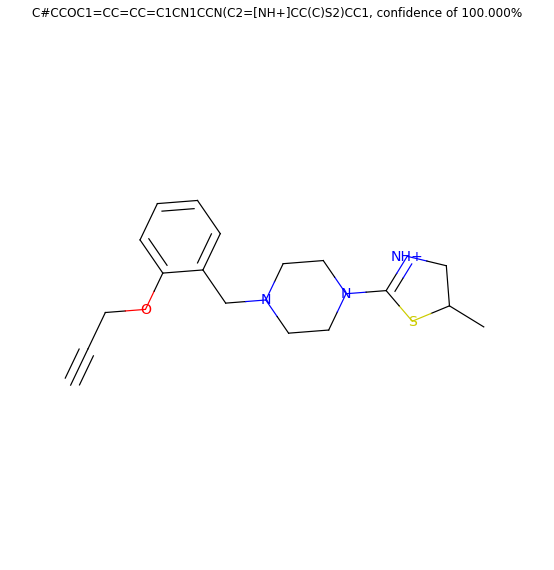

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [37]:
best_string = high_scores[0][1]
mol = Chem.MolFromSmiles(best_string)
fig = Draw.MolToMPL(mol)
plt.title(f'{best_string}, confidence of {confidence * 100:.3f}%')
plt.axis('off')
plt.show()
mblock = Chem.MolToMolBlock(mol)
view = py3Dmol.view(width=200, height=200)
view.addModel(mblock, 'mol')
view.setStyle('stick')
view.zoomTo()
view.show()

In [38]:
print(f'{len(set([i[1] for i in high_scores]))} unique chemicals')

6 unique chemicals


In [39]:
final_result_df = pd.DataFrame(set(high_scores))
final_result_df.columns = ['score', 'string']
final_result_df.sort_values(by='score', ascending=False)

,score,string
1,-3.576281e-07,CC(OC1=CC=C(Cl)C(Cl)=C1)1CC[NH+](CC2CCC2)CC1
5,-1.986827e-06,CC[NH+]1CC(C2=CC=C=C(F)C=C2C1)C1=CC[NH+](C)C1
2,-3.298140e-06,O=C1N(C[NH+])S1
3,-2.455802e-05,O=C(CC1=C)S1
4,-2.098148e-04,CCN1CCCC1
0,-3.204694e-04,C#CCOC1=CC=CC=C1CN1CCN(C2=[NH+]CC(C)S2)CC1


In [80]:
final_result_df.to_csv(f'{os.getcwd()}//final_dopa_antagonists.csv', index=False)